# Predicting LOL Matches While Learning PyTorch Basics (Part 2)

In [1]:
#env
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, TensorDataset, DataLoader

In [2]:
proj_name = 'lol_nn'

---

In [3]:
df = pd.read_csv('/notebooks/storage/high_diamond_ranked_10min.csv')

In [4]:
df.drop(['gameId','redFirstBlood','blueTotalGold','redTotalGold','blueTotalExperience','redTotalExperience','redGoldDiff','redExperienceDiff','redKills','redDeaths'], axis=1, inplace=True)

In [5]:
df.head()

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redAvgLevel,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,8,0,0,0,0,6.8,197,55,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,2,2,1,1,1,6.8,240,52,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,14,0,0,0,0,6.8,203,28,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,10,0,0,0,0,7.0,235,47,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,7,1,1,0,0,7.0,225,67,22.5,1740.4


In [6]:
targets = df[['blueWins']].values.flatten()
features = df.drop('blueWins', axis=1).values

In [7]:
test_size = int(.10 * 9879) # represents size of validation set
val_size = test_size
train_size = 9879 - test_size*2
train_size , val_size, test_size

(7905, 987, 987)

In [8]:
dataset = TensorDataset(torch.tensor(features).float(), torch.tensor(targets))
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [9]:
batch_size = 128

In [10]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, pin_memory=True)

In [11]:
for x,y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 29]) torch.Size([128])


In [12]:
input_size = 29
output_size = 2

#### ^^^ what we've done in [part one](https://jovian.ml/richardso21/lol-logistic) ^^^

---

## The Model & Defining The Training Loop

In [13]:
class LOLModelmk2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [14]:
crit = F.cross_entropy #criterion
opt_func = torch.optim.SGD #optimizer function (w/o params or lr)

In [15]:
def fit(epochs, lr, model, train_loader, val_loader):
    h = []
    # define optimizer
    opt = opt_func(model.parameters(), lr=lr)
    # loop for num of epochs
    for epoch in range(epochs):
        # training per epoch (iterate tru each batch)
        for inputs, labels in train_loader:
            # put inputs to gpu (explained later)
            inputs, labels = inputs.to(device), labels.to(device)
            # using optimizer & loss
            opt.zero_grad()
            _, loss = step(inputs, labels)
            loss.backward()
            opt.step()
        # evaluate model on validation set every epoch
        val_results = evaluate(model, val_loader)
        # printing as output every 5 epochs
        if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
            print(f'Epoch #{epoch + 1} ==> Val Loss: {val_results["avg_loss"]} | Val Acc: {val_results["avg_acc"]}')
        h.append(val_results)
    return h
        
def evaluate(model, loader):
    losses = []
    accs = []
    # tracking gradient not needed
    with torch.no_grad():
        # looping over data loader
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outs, loss = step(inputs, labels, evaluate=True)
            # computing accuracy (function below)
            acc = accuracy(outs, labels)
            losses.append(loss)
            accs.append(acc)
    # avg loss + acc for all data on loader
    avg_loss = sum(losses) / len(losses)
    avg_acc = sum(accs) / len(accs)
    return {'avg_loss':avg_loss, 'avg_acc':avg_acc}
            
# function to input features into model (used for training + validation)
def step(inputs, labels, evaluate=False):
    if evaluate:
        model.eval()
    else:
        model.train()
    outs = model(inputs)
    loss = crit(outs, labels)
    return outs, loss

def accuracy(outs, labels):
    # find the highest probability of the two categories
    _, preds = torch.max(outs, dim=1)
    # return % of correct predictions (matched w/ labels)
    return (torch.tensor(torch.sum(preds==labels).item() / len(preds))) * 100    

In [50]:
def visualize(hist, acc=False):
    losses = [x['avg_loss'] for x in hist]
    accs = [x['avg_acc'] for x in hist]
    if acc:
        plt.plot(accs)
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
    else:
        plt.plot(losses)
        plt.ylabel('Losses')
        plt.title('Losses over Epochs')
    plt.xlabel('Epochs')
    plt.show()

---

## Using the GPU

In [16]:
torch.cuda.is_available()

True

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [18]:
device

device(type='cuda')

In [19]:
model = LOLModelmk2().to(device)

In [20]:
model

LOLModelmk2(
  (fc1): Linear(in_features=29, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)

---

## Training

In [21]:
before_train = evaluate(model, test_loader)
before_train

{'avg_loss': tensor(16.9297, device='cuda:0'), 'avg_acc': tensor(50.1231)}

In [22]:
hist = [evaluate(model, val_loader)]

In [23]:
hist += fit(25, 1e-4, model, train_loader, val_loader)

Epoch #5 ==> Val Loss: 0.5858711004257202 | Val Acc: 72.49839782714844
Epoch #10 ==> Val Loss: 0.5741142630577087 | Val Acc: 72.8903579711914
Epoch #15 ==> Val Loss: 0.562758207321167 | Val Acc: 73.81876373291016
Epoch #20 ==> Val Loss: 0.5533215999603271 | Val Acc: 73.23282623291016
Epoch #25 ==> Val Loss: 0.5552922487258911 | Val Acc: 72.4337387084961


In [24]:
hist += fit(50, 1e-5, model, train_loader, val_loader)

Epoch #5 ==> Val Loss: 0.5500308871269226 | Val Acc: 73.0045166015625
Epoch #10 ==> Val Loss: 0.5507445931434631 | Val Acc: 73.1021728515625
Epoch #15 ==> Val Loss: 0.5507141351699829 | Val Acc: 73.1833267211914
Epoch #20 ==> Val Loss: 0.5494900345802307 | Val Acc: 73.41163635253906
Epoch #25 ==> Val Loss: 0.550394594669342 | Val Acc: 73.11866760253906
Epoch #30 ==> Val Loss: 0.5509869456291199 | Val Acc: 73.24932098388672
Epoch #35 ==> Val Loss: 0.5522085428237915 | Val Acc: 72.63038635253906
Epoch #40 ==> Val Loss: 0.5529235601425171 | Val Acc: 73.13516998291016
Epoch #45 ==> Val Loss: 0.5493339896202087 | Val Acc: 73.0045166015625
Epoch #50 ==> Val Loss: 0.5490845441818237 | Val Acc: 73.31398010253906


In [25]:
after_train = evaluate(model, test_loader)
after_train

{'avg_loss': tensor(0.5606, device='cuda:0'), 'avg_acc': tensor(71.5522)}

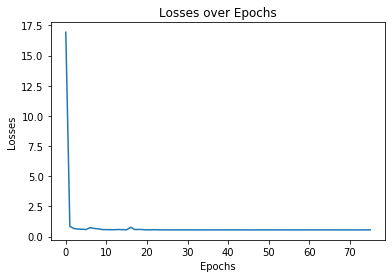

In [53]:
visualize(hist)

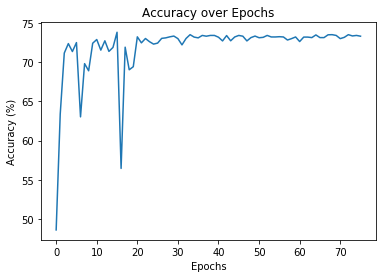

In [54]:
visualize(hist, acc=True)

---

In [55]:
class LOLModelmk3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        
        self.dp = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp(x)
        x = F.relu(self.fc2(x))
        x = self.dp(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [56]:
model = LOLModelmk3().to(device)

In [57]:
model

LOLModelmk3(
  (fc1): Linear(in_features=29, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=2, bias=True)
  (dp): Dropout(p=0.5, inplace=False)
)

In [58]:
before_train = evaluate(model, test_loader)
before_train

{'avg_loss': tensor(5.1686, device='cuda:0'), 'avg_acc': tensor(38.8061)}

In [59]:
hist = [evaluate(model, val_loader)]

In [60]:
hist += fit(25, 1e-4, model, train_loader, val_loader)

Epoch #5 ==> Val Loss: 0.6694241166114807 | Val Acc: 72.38557434082031
Epoch #10 ==> Val Loss: 0.5765219330787659 | Val Acc: 72.48323059082031
Epoch #15 ==> Val Loss: 0.5806542038917542 | Val Acc: 70.12164306640625
Epoch #20 ==> Val Loss: 0.5868121981620789 | Val Acc: 70.93589782714844
Epoch #25 ==> Val Loss: 0.5947368741035461 | Val Acc: 71.147705078125


In [61]:
hist += fit(50, 1e-5, model, train_loader, val_loader)

Epoch #5 ==> Val Loss: 0.5914079546928406 | Val Acc: 71.3595199584961
Epoch #10 ==> Val Loss: 0.5925575494766235 | Val Acc: 71.245361328125
Epoch #15 ==> Val Loss: 0.5919591784477234 | Val Acc: 71.3595199584961
Epoch #20 ==> Val Loss: 0.5930008888244629 | Val Acc: 71.3595199584961
Epoch #25 ==> Val Loss: 0.5931984186172485 | Val Acc: 71.3595199584961
Epoch #30 ==> Val Loss: 0.5914367437362671 | Val Acc: 71.57132720947266
Epoch #35 ==> Val Loss: 0.5897141695022583 | Val Acc: 71.57132720947266
Epoch #40 ==> Val Loss: 0.5893092155456543 | Val Acc: 71.47367095947266
Epoch #45 ==> Val Loss: 0.5914409160614014 | Val Acc: 71.68548583984375
Epoch #50 ==> Val Loss: 0.5912692546844482 | Val Acc: 71.39251708984375


In [62]:
after_train = evaluate(model, test_loader)
after_train

{'avg_loss': tensor(0.5919, device='cuda:0'), 'avg_acc': tensor(70.9497)}

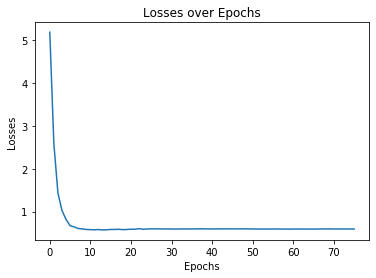

In [63]:
visualize(hist)

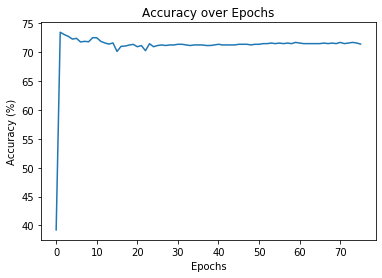

In [64]:
visualize(hist, acc=True)

---

In [65]:
class LOLModelmk4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(num_features=64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        
        self.dp = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dp(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dp(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [81]:
model = LOLModelmk4().to(device)

In [82]:
before_train = evaluate(model, test_loader)
before_train

{'avg_loss': tensor(16.7735, device='cuda:0'), 'avg_acc': tensor(49.6651)}

In [83]:
hist = [evaluate(model, val_loader)]

In [84]:
hist += fit(25, 1e-3, model, train_loader, val_loader)

Epoch #5 ==> Val Loss: 0.6776890754699707 | Val Acc: 59.275115966796875
Epoch #10 ==> Val Loss: 0.646669864654541 | Val Acc: 72.59605407714844
Epoch #15 ==> Val Loss: 0.6271384358406067 | Val Acc: 73.16548919677734
Epoch #20 ==> Val Loss: 0.6076155304908752 | Val Acc: 73.55611419677734
Epoch #25 ==> Val Loss: 0.591722846031189 | Val Acc: 74.12689208984375


In [ ]:
hist += fit(50, 1e-4, model, train_loader, val_loader)

Epoch #5 ==> Val Loss: 0.5906327962875366 | Val Acc: 74.0938949584961
Epoch #10 ==> Val Loss: 0.5916613340377808 | Val Acc: 73.100830078125
Epoch #15 ==> Val Loss: 0.5879733562469482 | Val Acc: 73.4103012084961
Epoch #20 ==> Val Loss: 0.5868173837661743 | Val Acc: 73.491455078125
Epoch #25 ==> Val Loss: 0.5857055187225342 | Val Acc: 74.11038970947266


In [72]:
after_train = evaluate(model, test_loader)
after_train

{'avg_loss': tensor(0.5895, device='cuda:0'), 'avg_acc': tensor(72.9028)}

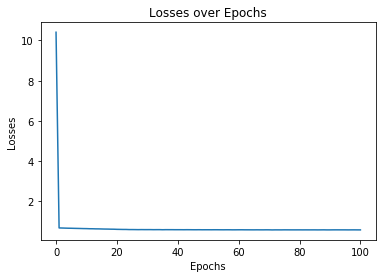

In [73]:
visualize(hist)

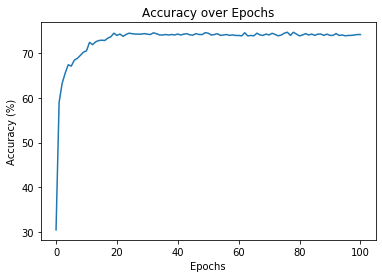

In [74]:
visualize(hist, acc=True)

In [5]:
jovian.commit(filename=proj_name, project=proj_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "richardso21/lol-nn" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/richardso21/lol-nn


'https://jovian.ml/richardso21/lol-nn'